In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
from torch.utils.tensorboard import SummaryWriter


In [2]:
class MyDataset(Dataset):
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(MyDataset, self).__init__()
        self.train = train
        self.transforms = transforms

        file_path = root_dir + 'imgs/*.jpg'
        file_mask_path = root_dir + 'masks/*.gif'

        self.images = sorted(glob(file_path))
        self.image_mask = sorted(glob(file_mask_path))

        # manually split the train/valid data
        split_ratio = int(len(self.images) * 0.7)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]

    def __getitem__(self, index: int):
        image = Image.open(self.images[index]).convert('RGB')
        image_mask = Image.open(self.image_mask[index]).convert('L')

        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)

        return {'img': image, 'mask': image_mask}

    def __len__(self):
        return len(self.images)


In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor):
        return self.block(x)


class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = T.CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)

        return output


class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.copyAndCrop = CopyAndCrop()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])

        # PixelShuffle, UpSample will modify the output channel (you can add extra operation to update the channel, e.g.conv2d)
        # preffer use convTranspose2d, it won't modify the output channel
        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])

        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)

    def forward(self, x: torch.Tensor):
        # encod
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)

        x = self.bottleneck(x)

        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)

        output = self.final_conv(x)
        return output


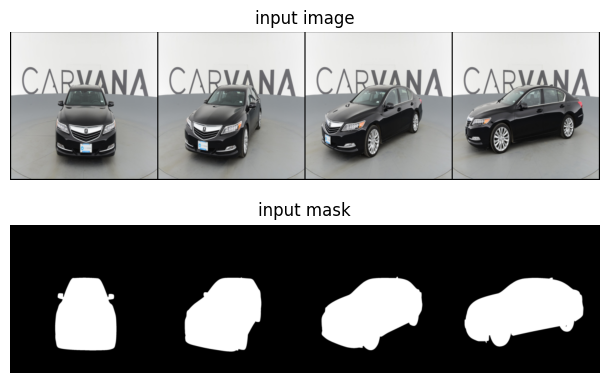

100%|██████████| 300/300 [01:05<00:00,  4.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


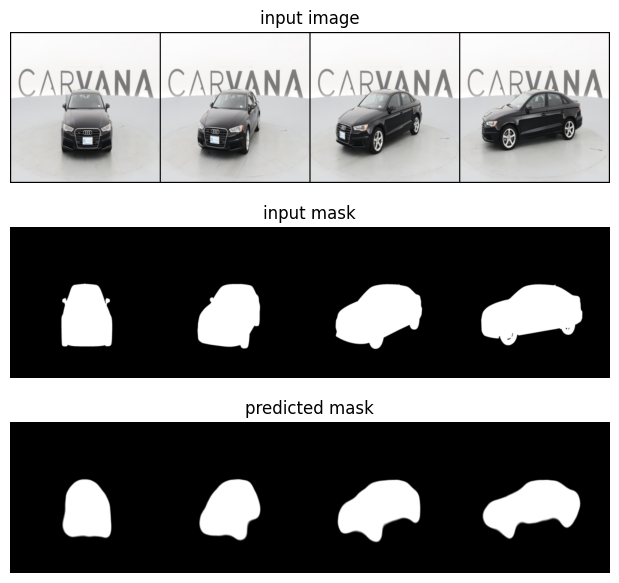

epochs - 1/14 [700/700], dice score: -0.3669969552618204, train loss: 0.14841238519442934, val loss: 0.14623737826943398


100%|██████████| 300/300 [01:09<00:00,  4.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


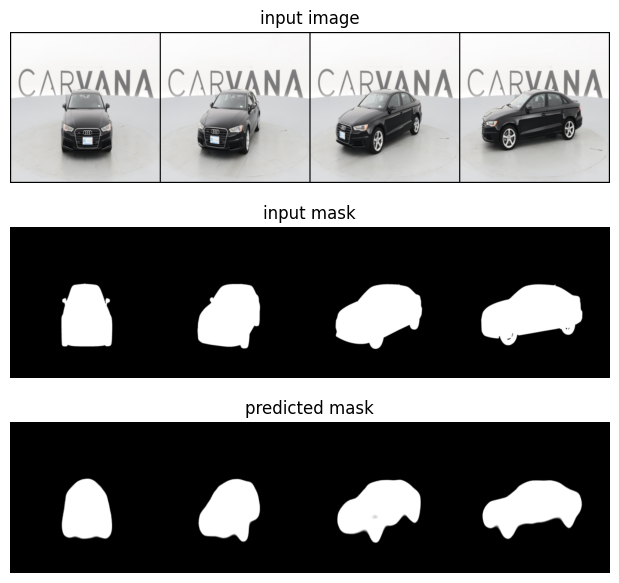

epochs - 2/14 [700/700], dice score: -0.2686758923565503, train loss: 0.05487638056278229, val loss: 0.12333898903802037


100%|██████████| 300/300 [00:52<00:00,  5.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


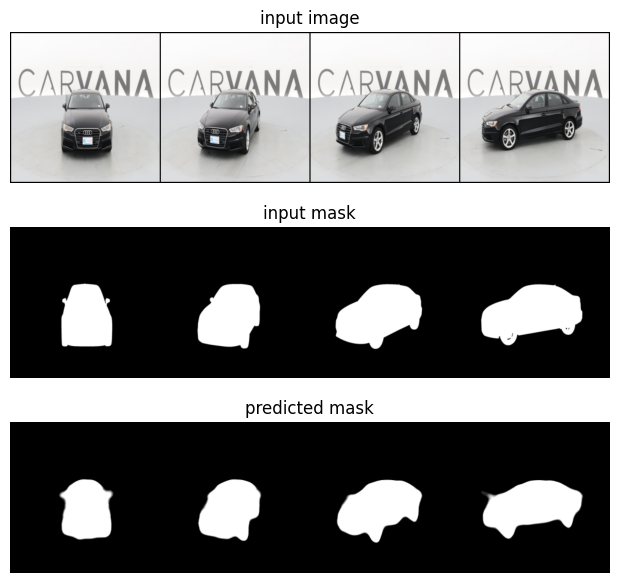

epochs - 3/14 [700/700], dice score: -0.3413667865524379, train loss: 0.035184067918785984, val loss: 0.07799545078227918


100%|██████████| 300/300 [00:50<00:00,  5.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


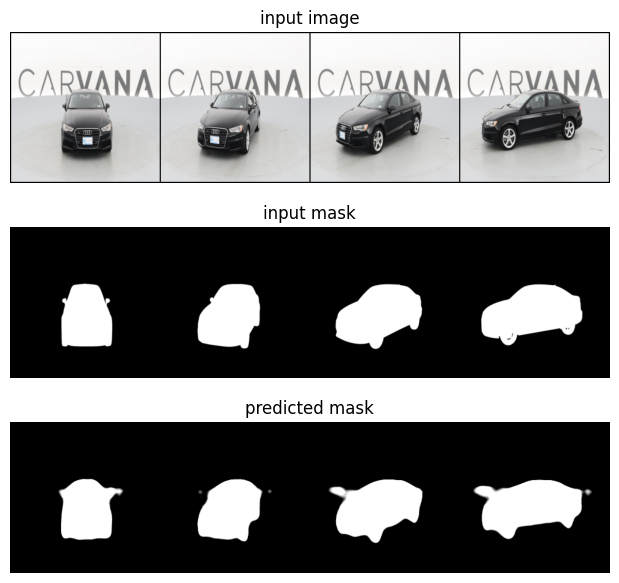

epochs - 4/14 [700/700], dice score: -0.49578947138041257, train loss: 0.026665102908653874, val loss: 0.03618080817162991


100%|██████████| 300/300 [00:50<00:00,  5.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


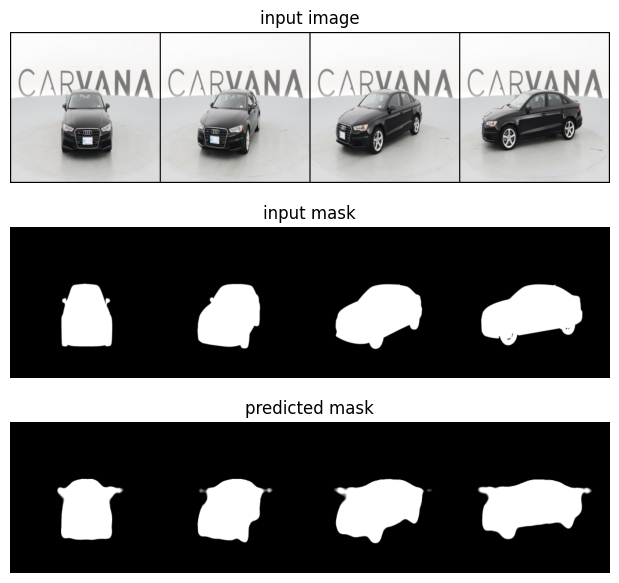

epochs - 5/14 [700/700], dice score: -0.577375278621912, train loss: 0.02217831772752106, val loss: 0.03148068203901251


100%|██████████| 300/300 [00:50<00:00,  5.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


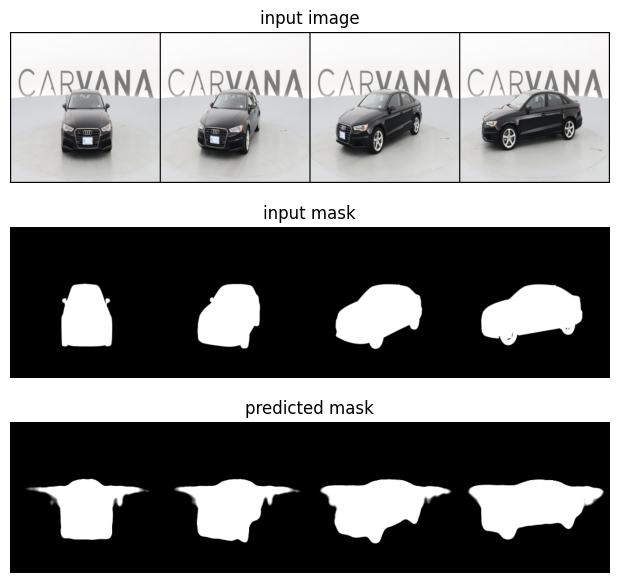

epochs - 6/14 [700/700], dice score: -0.7222153082489967, train loss: 0.019903195215655225, val loss: 0.03763053722679615


100%|██████████| 300/300 [00:51<00:00,  5.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


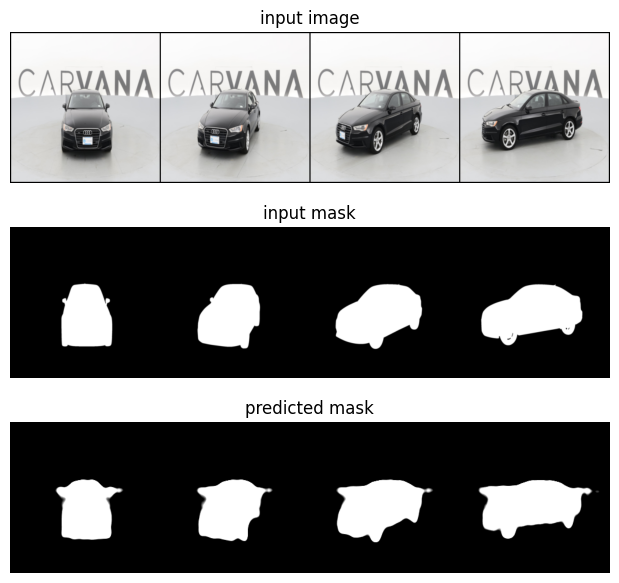

epochs - 7/14 [700/700], dice score: -0.40959717011079194, train loss: 0.01801288233537759, val loss: 0.05501926744356751


100%|██████████| 300/300 [00:52<00:00,  5.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


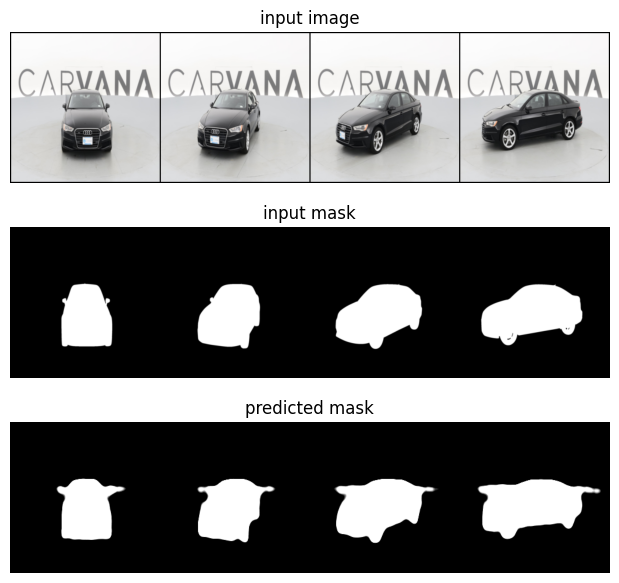

epochs - 8/14 [700/700], dice score: -0.6367479988435905, train loss: 0.016782930344343184, val loss: 0.03084769339300692


100%|██████████| 300/300 [00:53<00:00,  5.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


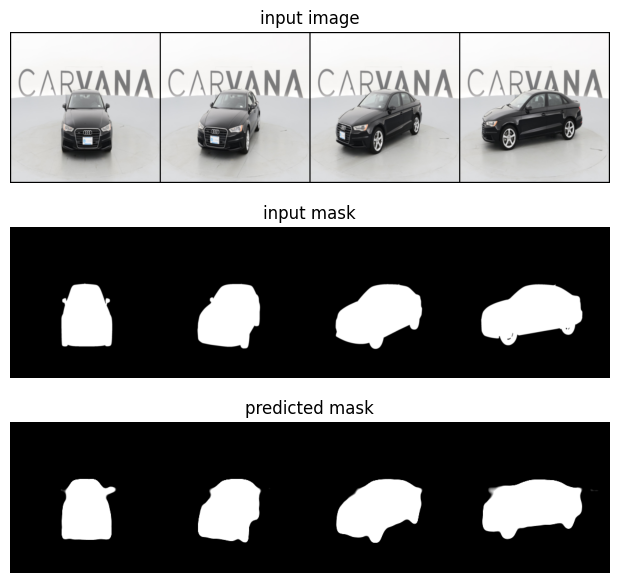

epochs - 9/14 [700/700], dice score: -0.5650482903917631, train loss: 0.015836872278845737, val loss: 0.02884656450090309


100%|██████████| 300/300 [00:53<00:00,  5.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


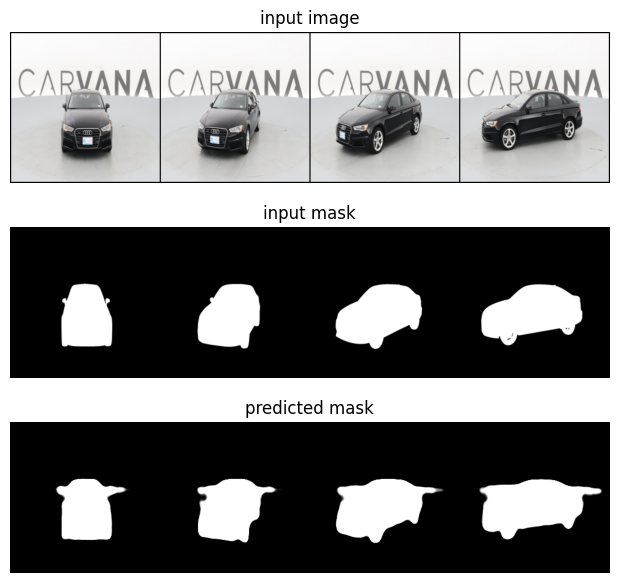

epochs - 10/14 [700/700], dice score: -0.5771588737765948, train loss: 0.014961443793560777, val loss: 0.02876753089328607


100%|██████████| 300/300 [00:52<00:00,  5.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


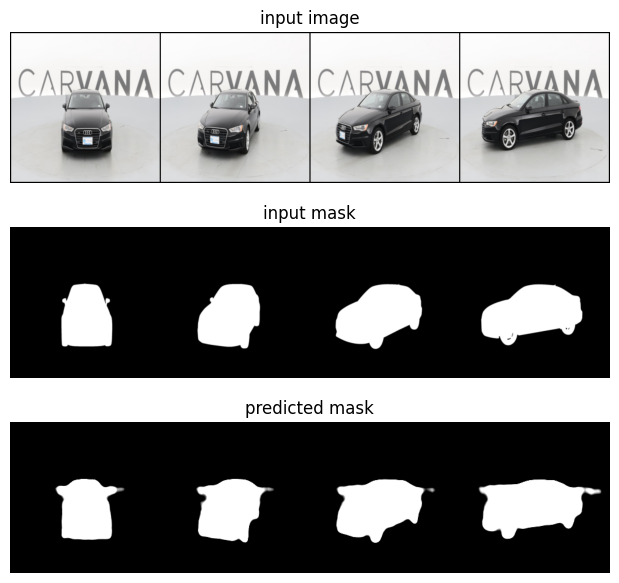

epochs - 11/14 [700/700], dice score: -0.48008045136928557, train loss: 0.014316565668476479, val loss: 0.03937680441265305


100%|██████████| 300/300 [00:53<00:00,  5.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


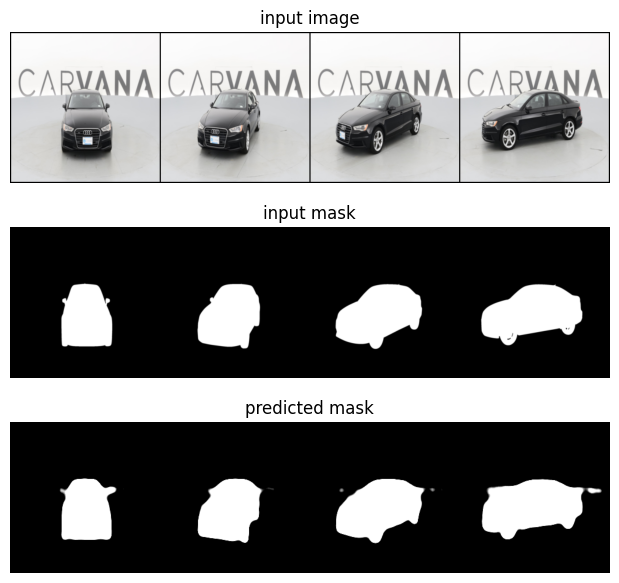

epochs - 12/14 [700/700], dice score: -0.5977878818909327, train loss: 0.013931000776855008, val loss: 0.026021093431239328


100%|██████████| 300/300 [00:50<00:00,  5.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


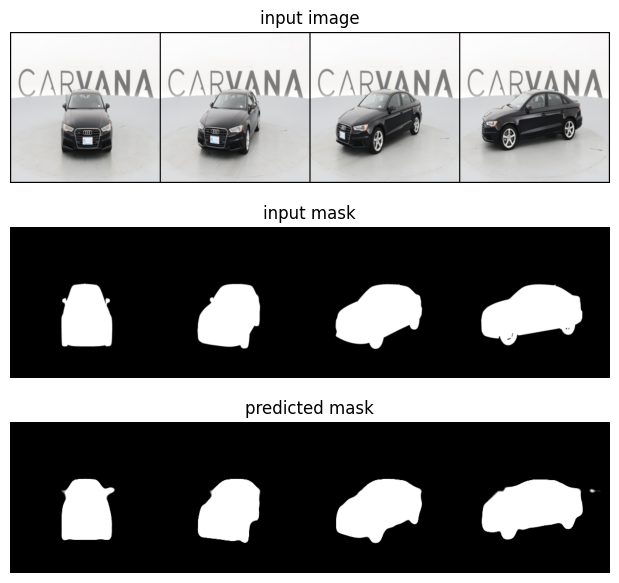

epochs - 13/14 [700/700], dice score: -0.5359743639330069, train loss: 0.013271445679877486, val loss: 0.025644305475677052


100%|██████████| 300/300 [00:53<00:00,  5.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


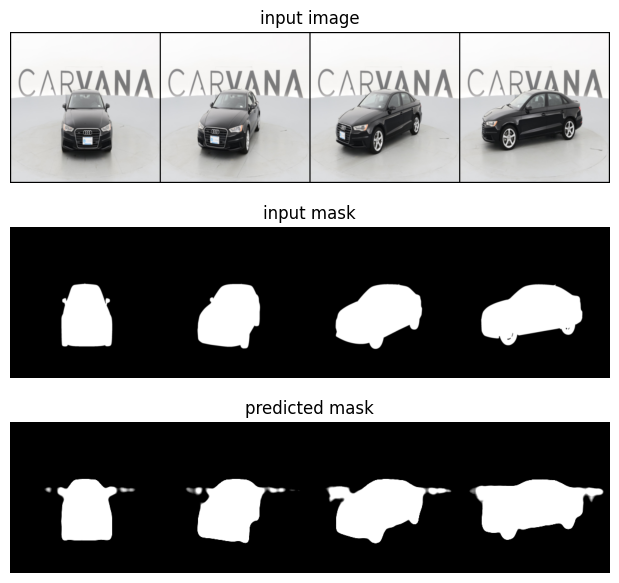

epochs - 14/14 [700/700], dice score: -0.617779580851396, train loss: 0.012827198696322739, val loss: 0.02724482319628199


In [4]:
batch_size = 4
n_iters = 10000
epochs = 10
learning_rate = 0.0002
n_workers = 0
width = 256
height = 256
channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 44
random.seed(seed)
torch.manual_seed(seed)

if __name__ == '__main__':
    transforms = T.Compose([
        T.Resize((width, height)),
        T.ToTensor(),
        #     T.Normalize(mean=[0.485, 0.456, 0.406],
        #                 std=[0.229, 0.224, 0.225]),
        #     T.RandomHorizontalFlip()
    ])
    train_dataset = MyDataset(root_dir='D:\\Cpp\\data_structure\\PythonBase\\dataset\\train\\',
                              train=True,
                              transforms=transforms)
    val_dataset = MyDataset(root_dir='D:\\Cpp\\data_structure\\PythonBase\\dataset\\train\\',
                            train=False,
                            transforms=transforms)

    train_dataset_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=False,
                                      num_workers=n_workers)
    val_dataset_loader = DataLoader(dataset=val_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=n_workers)
    # print(train_dataset_loader.sampler)
    samples = next(iter(train_dataset_loader))
    # samples = train_dataset_loader[0]

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                           (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                           (1, 2, 0)), cmap='gray')

    plt.show()

    def dice_score(pred: torch.Tensor, mask: torch.Tensor):
        dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
        return np.mean(dice.cpu().numpy())

    def iou_score(pred: torch.Tensor, mask: torch.Tensor):
        pass


    def plot_pred_img(samples, pred):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
        fig.tight_layout()

        ax1.axis('off')
        ax1.set_title('input image')
        ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                                (1, 2, 0)))

        ax2.axis('off')
        ax2.set_title('input mask')
        ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                                (1, 2, 0)), cmap='gray')

        ax3.axis('off')
        ax3.set_title('predicted mask')
        ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                                (1, 2, 0)), cmap='gray')

        plt.show()


    def plot_train_progress(model):
        #     model.eval()

        #     with torch.no_grad():
        samples = next(iter(val_dataset_loader))
        val_img = samples['img'].to(device)
        val_mask = samples['mask'].to(device)

        pred = model(val_img)

        plot_pred_img(samples, pred.detach())


    def train(model, optimizer, criteration, scheduler=None):
        train_losses = []
        val_lossess = []
        lr_rates = []

        # calculate train epochs
        epochs = int(n_iters / (len(train_dataset) / batch_size))

        for epoch in range(epochs):
            model.train()
            train_total_loss = 0
            train_iterations = 0

            for idx, data in enumerate(tqdm(train_dataset_loader)):
                train_iterations += 1
                train_img = data['img'].to(device)
                train_mask = data['mask'].to(device)

                optimizer.zero_grad()
                # speed up the training
                with torch.set_grad_enabled(True):
                    train_output_mask = model(train_img)
                    train_loss = criterion(train_output_mask, train_mask)
                    train_total_loss += train_loss.item()

                train_loss.backward()
                optimizer.step()

            train_epoch_loss = train_total_loss / train_iterations
            train_losses.append(train_epoch_loss)

            # evaluate mode
            model.eval()
            with torch.no_grad():
                val_total_loss = 0
                val_iterations = 0
                scores = 0

                for vidx, val_data in enumerate(tqdm(val_dataset_loader)):
                    val_iterations += 1
                    val_img = val_data['img'].to(device)
                    val_mask = val_data['mask'].to(device)

                    with torch.set_grad_enabled(False):
                        pred = model(val_img)

                        val_loss = criterion(pred, val_mask)
                        val_total_loss += val_loss.item()
                        scores += dice_score(pred, val_mask)

                val_epoch_loss = val_total_loss / val_iterations
                dice_coef_scroe = scores / val_iterations

                val_lossess.append(val_epoch_loss)

                plot_train_progress(model)
                print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}'.format(
                    epoch + 1, epochs,
                    idx + 1, len(train_dataset_loader),
                    dice_coef_scroe, train_epoch_loss, val_epoch_loss
                ))
                torch.save(model, 'modelCar' + str(epoch) + '.pkl')
            lr_rates.append(optimizer.param_groups[0]['lr'])
            if scheduler:
                scheduler.step()  # decay learning rate
                print('LR rate:', scheduler.get_last_lr())


        return {
            'lr': lr_rates,
            'train_loss': train_losses,
            'valid_loss': val_lossess
        }
    model = UNet(in_channels=3, out_channels=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    # criterion = smp.losses.DiceLoss(mode='binary')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = train(model, optimizer, criterion)


In [5]:
import torch
import torchvision
import cv2
from PIL import Image
import numpy as np
# from model import Unet
# from utils import (
#     load_checkpoint,
#     )


if __name__== "__main__":
    model = Unet(in_channels=3, out_channels=1).to("cuda")
    model.eval()
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
    img = input('Input image filename:')
    name=img.replace(".jpg", "out")
    image=Image.open(img)
    orininal_h = np.array(image).shape[0]
    orininal_w = np.array(image).shape[1]
    image = np.array(Image.open(img).convert("RGB").resize((240,160), Image.BICUBIC))

    image=np.expand_dims(np.transpose(image, (2, 0, 1)),0)
    print(image.shape)
    image=torch.from_numpy(image)
    image = image.float()
    image /= 255.0
    image = image.cuda()
    with torch.no_grad():
        preds = torch.sigmoid(model(image))
        preds = (preds > 0.5).float()
        print(preds.shape)

    #注释的代码是将图像恢复到原来的尺寸
    #preds = preds.cpu().numpy()
    #preds=np.squeeze(preds,axis=(0,1))
    #preds = cv2.resize(preds, dsize=(orininal_w, orininal_h), interpolation=cv2.INTER_LINEAR)
    #preds = torch.from_numpy(preds)
    torchvision.utils.save_image(
        preds, f"{name}.png"
    )




NameError: name 'Unet' is not defined